## Preparation

In [ ]:
import os
import pathlib
import pandas as pd
import esparx
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from commonpower.control.controllers import OptimalController
from commonpower.control.runners import DeploymentRunner
from commonpower.control.wrappers import SingleAgentWrapper
from commonpower.modeling import ModelHistory
from commonpower.utils.helpers import get_adjusted_cost
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
from toolbox import setup_system, setup_controller

In [2]:
current_path = pathlib.Path().absolute().parent

# path to data
data_path = current_path / "data"
data_path = data_path.resolve()
esparx_data_path = current_path / "esparx_artifacts/datasets"
esparx_data_path = esparx_data_path.resolve()

# path to esparx model weights
model_weights_path = current_path / "esparx_artifacts/models/tft"
model_weights_path = model_weights_path.resolve()

# path to rl model weights
rl_model_weights_path = current_path / 'models/PPO'
rl_model_weights_path = rl_model_weights_path.resolve()

# path to TFT hyperparameters
hp_file_path = current_path / "esparx_artifacts/hyperparameters/"
hp_file_path = hp_file_path.resolve()

In [3]:
control_sample_time = timedelta(minutes=10)
forecast_frequency = timedelta(minutes=10)
forecast_horizon = timedelta(minutes=6 * 10 * 6) # 6h (our forecaster predicts 1h, we will apply iteratively)
lookback_horizon = timedelta(minutes=10 * 12) # 2h (that's what out forecaster takes)
control_horizon = timedelta(minutes=24 * 10 * 6) # 24h

## Registering Inputs and Notebook in e-SparX

In [ ]:
# register TFT forecaster
esparx.register_code(
    name="TFT Forecaster Class",
    description="Script defining the TFTForecaster class inheriting from commonpower.data_forecasting.base.Forecaster.",
    file_type="PY",
    source_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/blob/main/usecases/ess_control/src/toolbox/tft_forecaster.py",
    download_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/raw/main/usecases/ess_control/src/toolbox/tft_forecaster.py?inline=false",
    pipeline_name="Wind Farm ESS Control",
)

# register setup_sytem script
esparx.register_code(
    name="Setup Wind Farm Control System",
    description="Script defining a function handling the setup of the control inputs. The function takes the paths to all required data files as input and outputs and returns a commonpower system object.",
    file_type="PY",
    source_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/blob/main/usecases/ess_control/src/toolbox/system_setup.py",
    download_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/raw/main/usecases/ess_control/src/toolbox/system_setup.py?inline=false",
    pipeline_name="Wind Farm ESS Control",
    source_name="Day-Ahead Electricity Price Data",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="Cleaned SCADA and Weather Data",
    target_name="Setup Wind Farm Control System",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="TFT Forecaster Class",
    target_name="Setup Wind Farm Control System",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="TFT",
    target_name="TFT Forecaster Class",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="TFT Tuned Hyperparameters",
    target_name="TFT Forecaster Class",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="TFT Parameters Tuned",
    target_name="TFT Forecaster Class",
)

# register this notebook
esparx.register_code(
    name="Train and Deploy RL Agent",
    description="Notebook training an RL agent to control the Energy Storage System at a wind farm. The trained agent is compared to an optimal controller in deployment.",
    file_type="IPYNB",
    source_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/blob/main/usecases/ess_control/src/b_train_and_deploy.ipynb",
    download_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/raw/main/usecases/ess_control/src/b_train_and_deploy.ipynb?inline=false",
    pipeline_name="Wind Farm ESS Control",
    source_name="Setup Wind Farm Control System",
)

CREATED artifact TFT Forecaster Class.
Pipeline Wind Farm ESS Control found.
CONNECTED artifact TFT Forecaster Class to pipeline Wind Farm ESS Control.

CREATED artifact Setup Wind Farm Control System.
Pipeline Wind Farm ESS Control found.
CONNECTED artifact Setup Wind Farm Control System to pipeline Wind Farm ESS Control.
CONNECTED Day-Ahead Electricity Price Data to Setup Wind Farm Control System within pipeline Wind Farm ESS Control.

The source artifact Cleaned SCADA and Weather Data was not linked to pipeline Wind Farm ESS Control yet.
CONNECTED artifact Cleaned SCADA and Weather Data to pipeline Wind Farm ESS Control.
CONNECTED Cleaned SCADA and Weather Data to Setup Wind Farm Control System within pipeline Wind Farm ESS Control.

CONNECTED TFT Forecaster Class to Setup Wind Farm Control System within pipeline Wind Farm ESS Control.

The source artifact TFT was not linked to pipeline Wind Farm ESS Control yet.
CONNECTED artifact TFT to pipeline Wind Farm ESS Control.
CONNECTED TF

## System Setup

In [5]:
sys, farm, _, ess = setup_system(
    data_path,
    esparx_data_path,
    model_weights_path,
    hp_file_path,
    forecast_frequency,
    forecast_horizon,
    lookback_horizon
)


SYSTEM OVERVIEW 
 
Nodes: 
    (RTPricedBusLinear): Farm  
       (RenewableGen): Wind Power Plant  
       (ESS): ESS  
    (ExternalGrid): Grid  

Lines: 



## Defining and Training the RL Controller (PPO Algorithm)

In [ ]:
# register model in e-SparX
esparx.register_model_free(
    name="RL Controller (PPO)",
    description="Reinforcement learning agent trained to control the Energy Storage System at a wind farm. The agent is trained using the Proximal Policy Optimization (PPO) algorithm.",
    file_type="PY",
    flavor="SB3",
    source_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/blob/main/usecases/ess_control/src/toolbox/controller_setup.py",
    download_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/raw/main/usecases/ess_control/src/toolbox/controller_setup.py?inline=false",
    pipeline_name="Wind Farm ESS Control",
)
esparx.connect(
    pipeline_name="Wind Farm ESS Control",
    source_name="RL Controller (PPO)",
    target_name="Train and Deploy RL Agent",
)

CREATED artifact RL Controller (PPO).
Pipeline Wind Farm ESS Control found.
CONNECTED artifact RL Controller (PPO) to pipeline Wind Farm ESS Control.

CONNECTED RL Controller (PPO) to Train and Deploy RL Agent within pipeline Wind Farm ESS Control.



In [7]:
agent, alg_config, runner = setup_controller(
    forecast_horizon=forecast_horizon,
    control_horizon=control_horizon,
    control_sample_time=control_sample_time,
    total_training_steps=100 * 24 * 6,
    rl_model_weights_path=rl_model_weights_path,
    sys=sys,
)

Model weights found. Loading pretrained agent.


In [8]:
if not os.path.exists(f"{rl_model_weights_path}.zip"):
    # train on daily data
    runner.run(n_steps=24*6)
else:
    print("Model already trained. Skipping training.")

Model already trained. Skipping training.


In [ ]:
# register model parameters in e-SparX
esparx.register_parameters(
    name="RL Controller (PPO) Parameters",
    description="Weights of the trained RL controller. The algorithm used for training was PPO.",
    file_type="ZIP",
    source_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/blob/main/usecases/ess_control/models/PPO.zip",
    download_url="https://gitlab.lrz.de/energy-management-technologies-public/e-sparx/-/raw/main/usecases/ess_control/models/PPO.zip?inline=false",
    pipeline_name="Wind Farm ESS Control",
    source_name="Train and Deploy RL Agent",
)

CREATED artifact RL Controller (PPO) Parameters.
Pipeline Wind Farm ESS Control found.
CONNECTED artifact RL Controller (PPO) Parameters to pipeline Wind Farm ESS Control.
CONNECTED Train and Deploy RL Agent to RL Controller (PPO) Parameters within pipeline Wind Farm ESS Control.



In [ ]:
# deploy for 1st to 10th Feb, 2022
eval_seed = 3
rl_model_history = ModelHistory([sys])
rl_deployer = DeploymentRunner(
    sys=sys, 
    global_controller=agent,  
    alg_config=alg_config,
    wrapper=SingleAgentWrapper,
    forecast_horizon=forecast_horizon,
    control_horizon=control_horizon,
    history=rl_model_history,
    dt=control_sample_time,
    seed=eval_seed,
    continuous_control=True,
)
rl_deployer.run(n_steps=10*24*6, fixed_start=datetime(2022, 2, 1))

In [9]:
# extract cost trajectory
farm_cost_rl = rl_model_history.get_history_for_element(farm, name='cost')
df_results = pd.DataFrame(farm_cost_rl, columns=['timestamp', 'profit_rl'])
df_results['profit_rl'] = -df_results['profit_rl'].values
# make timestamp column to index as datetime index
df_results['timestamp'] = pd.to_datetime(df_results['timestamp'])
df_results.set_index('timestamp', inplace=True)

# extract soc trajectory
soc_rl = rl_model_history.get_history_for_element(ess, name="soc")
df_soc = pd.DataFrame(soc_rl, columns=['timestamp', 'soc_rl'])
df_results['soc_rl'] = df_soc['soc_rl'].values
df_results['soc_rl'] = df_results['soc_rl'] / 300 # scale between 0 and 1 (battery has 0.3MWh capacity)

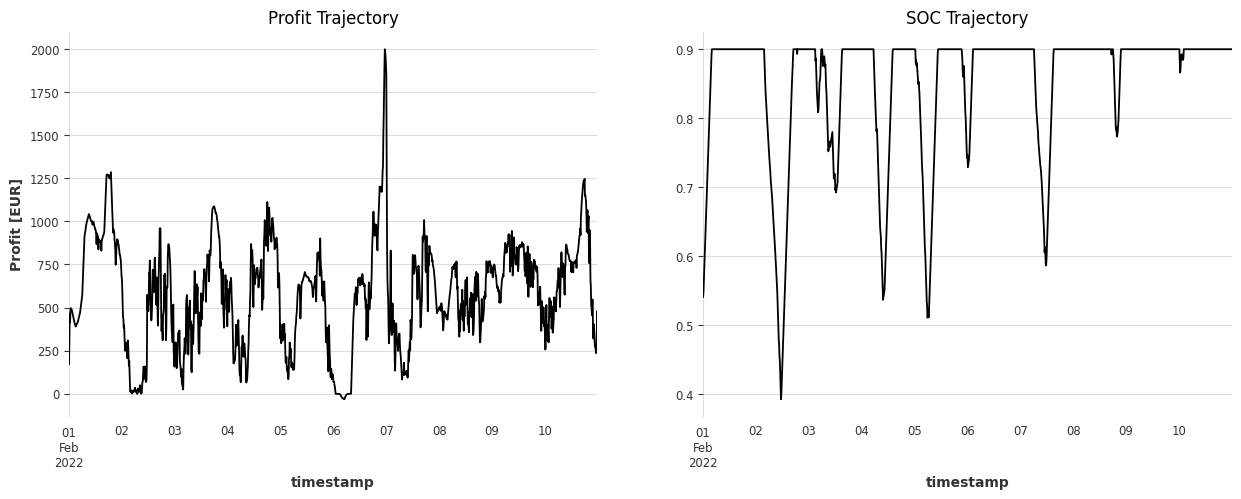

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_results['profit_rl'].plot(ax=ax[0])
ax[0].set_title('Profit Trajectory')
ax[0].set_ylabel('Profit [EUR]')
df_results['soc_rl'].plot(ax=ax[1])
ax[1].set_title('SOC Trajectory')
plt.show()

In [11]:
total_cost_rl = get_adjusted_cost(rl_model_history, farm)
print(f"Total profit using RL Controller (not adjusted): {round(sum(df_results['profit_rl'].values), 2)} EUR")
print(f"Total profit using RL Controller (adjusted): {round(-sum(total_cost_rl), 2)} EUR")

Total profit using RL Controller (not adjusted): 839938.57 EUR
Total profit using RL Controller (adjusted): 854302.91 EUR


In [10]:
esparx.register_results(
   name="Profit RL Controller (PPO)",
   description="The wind farm's total profit when using the RL Controller.",
   results={"Total Profit [EUR]": 854302.91},
   pipeline_name="Wind Farm ESS Control",
   source_name="Train and Deploy RL Agent",
)

CREATED artifact Profit RL Controller (PPO).
Pipeline Wind Farm ESS Control found.
CONNECTED artifact Profit RL Controller (PPO) to pipeline Wind Farm ESS Control.
CONNECTED Train and Deploy RL Agent to Profit RL Controller (PPO) within pipeline Wind Farm ESS Control.



### Benchmarking with Optimal Controller

In [ ]:
oc_model_history = ModelHistory([sys])
oc_deployer = DeploymentRunner(
    sys=sys, 
    global_controller=OptimalController('global'), 
    forecast_horizon=forecast_horizon,
    control_horizon=control_horizon,
    history=oc_model_history,
    dt=control_sample_time,
    seed=eval_seed,
    continuous_control=True,
)
oc_deployer.run(n_steps=10 * 24*6, fixed_start=datetime(2022, 2, 1))

In [13]:
# extract cost trajectory
farm_cost_oc = oc_model_history.get_history_for_element(farm, name='cost')
df_results_oc = pd.DataFrame(farm_cost_oc, columns=['timestamp', 'profit_oc'])
df_results_oc['profit_oc'] = -df_results_oc['profit_oc'].values

# extract soc trajectory
soc_oc = oc_model_history.get_history_for_element(ess, name="soc")
df_soc_oc = pd.DataFrame(soc_oc, columns=['timestamp', 'soc_oc'])
df_results_oc['soc_oc'] = df_soc_oc['soc_oc'].values
df_results_oc['soc_oc'] = df_results_oc['soc_oc'] / 300 # scale between 0 and 1 (battery has 0.3MWh capacity)

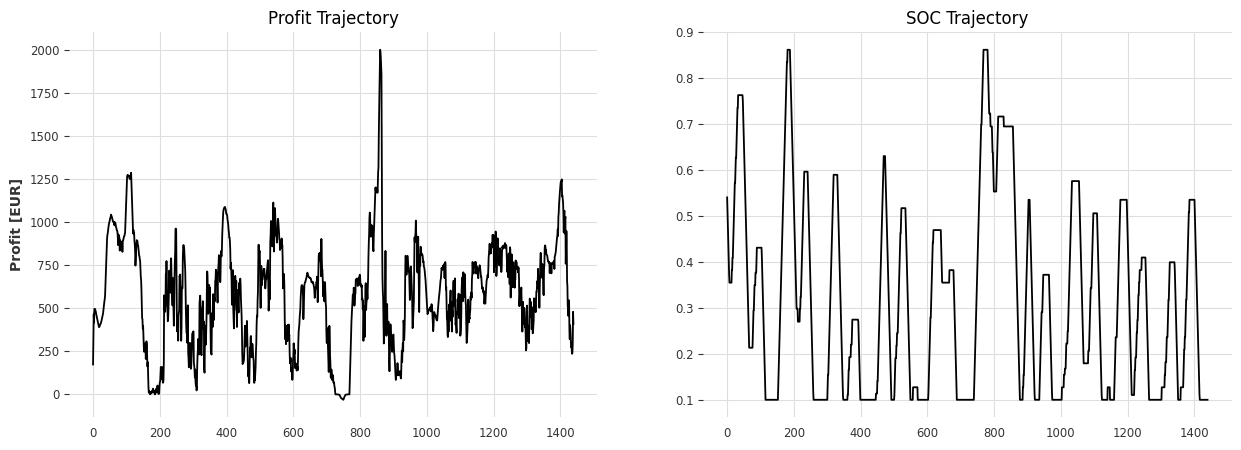

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
df_results_oc['profit_oc'].plot(ax=ax[0])
ax[0].set_title('Profit Trajectory')
ax[0].set_ylabel('Profit [EUR]')
df_results_oc['soc_oc'].plot(ax=ax[1])
ax[1].set_title('SOC Trajectory')
plt.show()

In [15]:
total_cost_oc = get_adjusted_cost(oc_model_history, farm)
print(f"Total profit using Optimal Control (not adjusted): {round(sum(df_results_oc['profit_oc'].values), 2)} EUR")
print(f"Total profit using Optimal Control (adjusted): {round(-sum(total_cost_oc), 2)} EUR")
print("For comparison:")
print(f"Total profit using the RL Controller (adjusted): {round(-sum(total_cost_rl), 2)} EUR")

Total profit using Optimal Control (not adjusted): 840180.62 EUR
Total profit using Optimal Control (adjusted): 854498.15 EUR
For comparison:
Total profit using the RL Controller (adjusted): 854302.91 EUR


In [13]:
esparx.register_results(
   name="Profit Optimal Control",
   description="The wind farm's total profit in case of optimal control.",
   results={"Total Profit [EUR]": 854498.15},
   pipeline_name="Wind Farm ESS Control",
   source_name="Train and Deploy RL Agent",
)

CREATED artifact Profit Optimal Control.
Pipeline Wind Farm ESS Control found.
CONNECTED artifact Profit Optimal Control to pipeline Wind Farm ESS Control.
CONNECTED Train and Deploy RL Agent to Profit Optimal Control within pipeline Wind Farm ESS Control.

